In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') # .experiments

Mounted at /content/gdrive


In [ ]:
!cp -r '/content/gdrive/My Drive/SSVEP_BR41N_IO/ssvep' /content
!pip install mat73

## Channel info in mat files

1. CH1: sample time
2. CH2- 9: EEG
3. CH10: trigger info
4. CH11: LDA classification output

## Sampling Rate: 256Hz
## Labels: classinfo_4_5.m

In [ ]:
with open('ssvep/classInfo_4_5.m') as f:
    targets_str= f.read().split('\n')

targets=[]
for label in targets_str[:-1]:
    targets.append(list(map(int,label.split(' '))))

In [ ]:
targets

[[1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1],
 [1, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 1, 0],
 [0, 0, 0, 1]]

In [ ]:
import mat73

sub1_train1_data = f'ssvep/subject_1_fvep_led_training_1.mat'
sub1_train2_data = f'ssvep/subject_1_fvep_led_training_2.mat'
sub2_train1_data = f'ssvep/subject_2_fvep_led_training_1.mat'
sub2_train2_data = f'ssvep/subject_2_fvep_led_training_2.mat'

data_dict_sub1_train1 = mat73.loadmat(sub1_train1_data)
data_dict_sub1_train2 = mat73.loadmat(sub1_train2_data)
data_dict_sub2_train1 = mat73.loadmat(sub2_train1_data)
data_dict_sub2_train2 = mat73.loadmat(sub2_train2_data)

print(data_dict_sub1_train1.keys(), data_dict_sub1_train2.keys(), data_dict_sub2_train1.keys(), data_dict_sub2_train2.keys())

data_sub1_train1 = data_dict_sub1_train1['y']
data_sub1_train2 = data_dict_sub1_train2['y']
data_sub2_train1 = data_dict_sub2_train1['y']
data_sub2_train2 = data_dict_sub2_train2['y']

print(data_sub1_train1.shape, data_sub1_train2.shape, data_sub2_train1.shape, data_sub2_train2.shape)

dict_keys(['y']) dict_keys(['y']) dict_keys(['y']) dict_keys(['y'])
(11, 57728) (11, 58112) (11, 58757) (11, 57697)


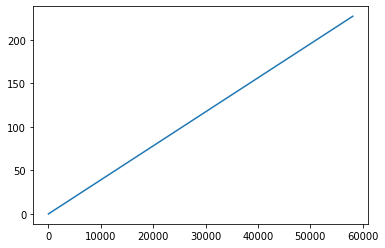

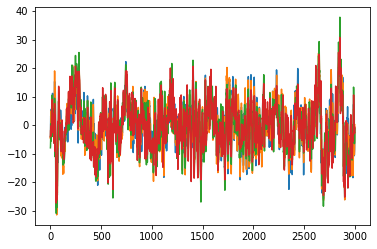

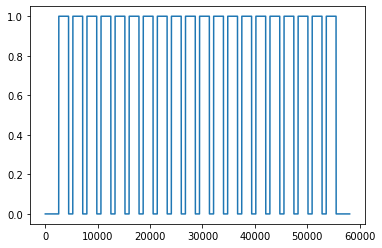

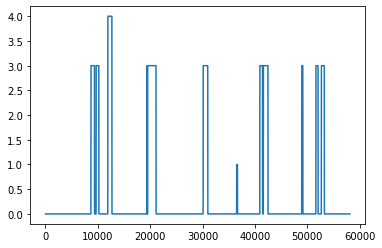

In [ ]:
name= "data_sub1_train2"
data = data_sub1_train2

import matplotlib.pyplot as plt

plt.plot(data[0])
plt.show()
plt.plot(data[1][10000:13000])
plt.plot(data[2][10000:13000])
plt.plot(data[3][10000:13000])
plt.plot(data[4][10000:13000])
plt.show()

plt.plot(data[9])
plt.show()
plt.plot(data[10])
plt.show()

In [ ]:
data.shape[1]/ data[0, -1] *3

768.0132160864553

In [ ]:
print((data_sub1_train1[10]==0).sum(), (data_sub1_train1[10]==1).sum(), (data_sub1_train1[10]==2).sum(), (data_sub1_train1[10]==3).sum(), (data_sub1_train1[10]==4).sum())
print((data_sub1_train2[10]==0).sum(), (data_sub1_train2[10]==1).sum(), (data_sub1_train2[10]==2).sum(), (data_sub1_train2[10]==3).sum(), (data_sub1_train2[10]==4).sum())
print((data_sub2_train1[10]==0).sum(), (data_sub2_train1[10]==1).sum(), (data_sub2_train1[10]==2).sum(), (data_sub2_train1[10]==3).sum(), (data_sub2_train1[10]==4).sum())
print((data_sub2_train2[10]==0).sum(), (data_sub2_train2[10]==1).sum(), (data_sub2_train2[10]==2).sum(), (data_sub2_train2[10]==3).sum(), (data_sub2_train2[10]==4).sum())

51072 0 0 6656 0
50832 156 0 6344 780
32289 5408 4212 1768 15080
29097 3328 2912 2548 19812


In [ ]:
def get_trigger_intervals(data):
    intervals_start= []
    intervals_end= []

    for i in range(0,len(data[9])-1):
        if data[9,i]==0 and data[9,i+1]==1:
            intervals_start.append(i+1)
        if data[9,i]==1 and data[9,i+1]==0:
            intervals_end.append(i+1)
    assert len(intervals_start)== len(intervals_end)

    import numpy as np
    intervals = np.array([intervals_start, intervals_end]).T

    return intervals

def get_label_array(data):
    intervals = get_trigger_intervals(data) 
    labels = np.zeros((data.shape[1]))
    class_=1
    for interval in intervals:
        labels[interval[0]:interval[1]]= class_
        class_+=1
        if class_==5:class_=1
    return labels

def get_samples(data_channel, intervals):
    output = []
    if len(data_channel.shape)==1: #(, 50000)
        for interval in intervals:
            output.append(data_channel[interval[0]: interval[1]])
    
    elif len(data_channel.shape)==2: #(8, 50000)
        for interval in intervals:
            output.append(data_channel[:,interval[0]: interval[1]])
    return np.array(output) # return chunks

def create_dataset(sample_eeg, sample_labels, window_size=10):
    eegs=[]
    labels=[]
    for idx in range(len(sample_eeg)):
        eeg_chunk = sample_eeg[idx]
        label_chunk= sample_labels[idx]
        for i in range(0, eeg_chunk.shape[1]- window_size, window_size):
            eegs.append(eeg_chunk[:,i:i+window_size])
            labels.append(label_chunk[i])
            for k in range(len(label_chunk)-1):
                assert label_chunk[k]==label_chunk[k+1]

    return np.array(eegs), np.array(labels)


In [ ]:
import numpy as np

In [ ]:
name= "data_sub1_train1"
data = data_sub1_train1

intervals = get_trigger_intervals(data)
labels = get_label_array(data)

samples_labels= get_samples(labels, intervals)
samples_lda_preds= get_samples(data[10], intervals)
samples_eeg= get_samples(data[1:9], intervals)

eegs,labels = create_dataset(samples_eeg, samples_labels, window_size=768) # window_size -> timestamps

import pickle

data_dict= {'eegs':eegs, 'labels': labels}
#with open(f'/content/gdrive/My Drive/SSVEP_BR41N_IO/{name}.pickle', 'wb') as f:
#    pickle.dump(data_dict, f)

In [ ]:
samples_lda_preds.shape

(20, 1882)

In [ ]:
np.mean(samples_lda_preds==samples_labels, axis=1)

array([0.        , 0.        , 0.60255048, 0.        , 0.        ,
       0.        , 0.63549416, 0.        , 0.        , 0.        ,
       0.22104145, 0.        , 0.        , 0.        , 0.33475027,
       0.        , 0.        , 0.        , 0.54941552, 0.        ])

In [ ]:
np.mean(np.mean(samples_lda_preds==samples_labels, axis=1))

0.1171625929861849

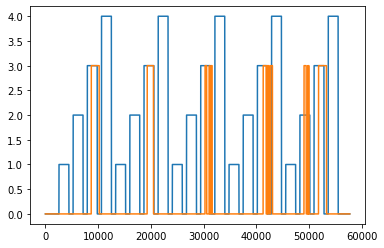

In [ ]:
plt.plot(get_label_array(data))
plt.plot(data[10])
plt.show()

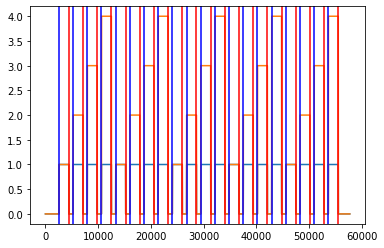

In [ ]:
plt.plot(data[9])
plt.plot(get_label_array(data))
for interval in intervals:
    plt.axvline(x=interval[0], color='b')
    plt.axvline(x=interval[1], color= 'r')

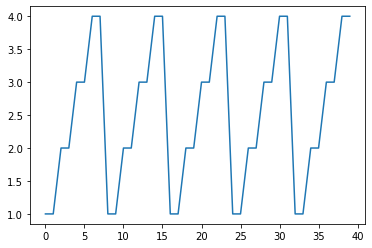

In [ ]:
plt.plot(labels)

In [ ]:
eegs[0].shape, labels[0]

((8, 768), 1.0)

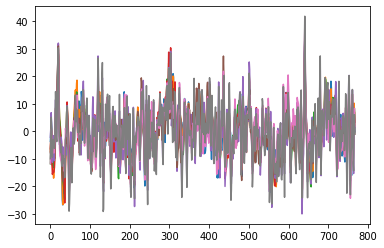

In [ ]:
plt.plot(eegs[0,0])
plt.plot(eegs[0,1])
plt.plot(eegs[0,2])
plt.plot(eegs[0,3])
plt.plot(eegs[0,4])
plt.plot(eegs[0,5])
plt.plot(eegs[0,6])
plt.plot(eegs[0,7])

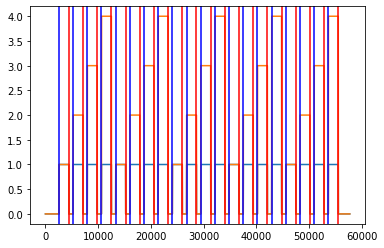

In [ ]:
plt.plot(data[9])
plt.plot(get_label_array(data))
for interval in intervals:
    plt.axvline(x=interval[0], color='b')
    plt.axvline(x=interval[1], color= 'r')

## Initial paper pipeline

In [ ]:
import scipy.signal

b1, a1 =scipy.signal.butter(N=7, Wn=[0.5, 30], btype='bandpass', fs=256)
b2, a2 =scipy.signal.iirnotch(w0= 50, Q=30, fs=256)

In [ ]:


def filter_eeg(eeg_signal):
    b1, a1 =scipy.signal.butter(N=6, Wn=[0.5, 30], btype='bandpass', fs=256)
    b2, a2 =scipy.signal.butter(N=6, Wn=[9.9, 10.1], btype='bandpass', fs=256)
    b3, a3 =scipy.signal.butter(N=6, Wn=[11.9, 12.1], btype='bandpass', fs=256)
    b4, a4 =scipy.signal.butter(N=6, Wn=[14.9, 15.1], btype='bandpass', fs=256)
    #b2, a2 =scipy.signal.iirnotch(w0= 50, Q=30, fs=256)

    sig1= np.power(scipy.signal.filtfilt(b1, a1, eeg_signal), 1)
    sig2= np.power(scipy.signal.filtfilt(b2, a2, eeg_signal), 1)
    sig3= np.power(scipy.signal.filtfilt(b3, a3, eeg_signal), 1)
    sig4= np.power(scipy.signal.filtfilt(b4, a4, eeg_signal), 1)

    filtered_eeg = sig2#+sig2+sig3+sig4
    #filtered_eeg2 = scipy.signal.filtfilt(b2, a2, filtered_eeg)
    return filtered_eeg

In [ ]:
eegs_1= eegs[np.where(labels==1)]
eegs_2= eegs[np.where(labels==2)]
eegs_3= eegs[np.where(labels==3)]
eegs_4= eegs[np.where(labels==4)]

10.0
10.0
10.0
10.0
10.0
10.0
9.666666666666666
10.0


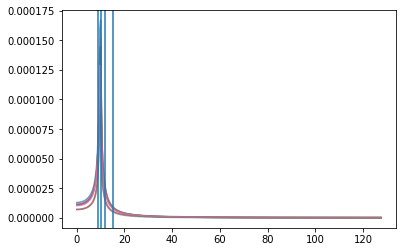

9.666666666666666
9.666666666666666
9.666666666666666
10.0
10.0
10.0
9.666666666666666
10.0


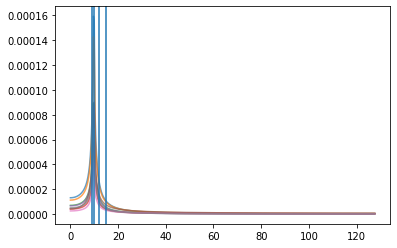

10.0
10.0
10.0
10.0
9.666666666666666
9.666666666666666
10.0
10.0


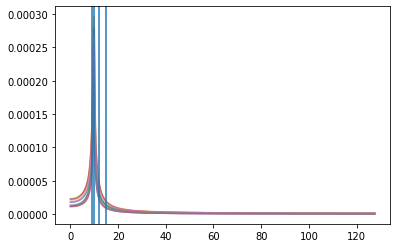

10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0


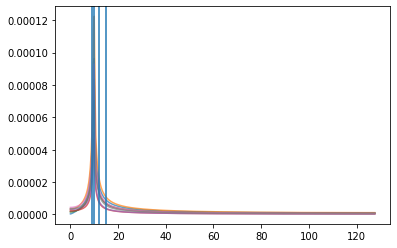

In [ ]:
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
import scipy.signal

chunk= -4
eeg_sets= [eegs_1, eegs_2, eegs_3, eegs_4]
freq= [9, 10, 12, 15]

for j in range(4):
    eeg_class= eeg_sets[j]
    for idx in range(8):
        y = filter_eeg(eeg_class[0,idx]) #0th window
        N = len(y)
        T = 1.0 / 256.0
        x = np.linspace(0.0, N*T, N, endpoint=False)
        yf = fft(y)
        xf = fftfreq(N, T)[:N//2]
        plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), alpha=0.7)
        arr= 2.0/N * np.abs(yf[0:N//2])
        print(xf[list(arr).index(np.max(arr))])

        plt.grid()
    plt.axvline(x=9)
    plt.axvline(x=10)
    plt.axvline(x=12)
    plt.axvline(x=15)

    plt.show()

9.0
9.0
9.0
9.0
9.0
9.0
9.0
9.0


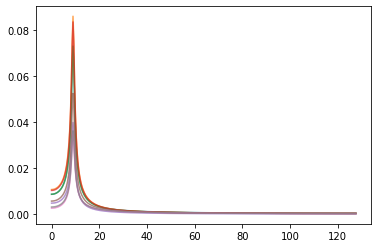

In [ ]:
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

chunk= -4
for idx in range(8):
    #y = eegs_1[0,idx]
    #N = len(y)
    #T = 1.0 / 256.0
    #x = np.linspace(0.0, N*T, N, endpoint=False)
    #yf = fft(y)
    #xf = fftfreq(N, T)[:N//2]
    #plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    #plt.grid()
    #plt.show()

    y = filter_eeg(eegs_1[0,idx])
    N = len(y)
    T = 1.0 / 256.0
    x = np.linspace(0.0, N*T, N, endpoint=False)
    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), alpha=0.7)
    arr= 2.0/N * np.abs(yf[0:N//2])
    print(xf[list(arr).index(np.max(arr))])

    plt.grid()
    #plt.show()

In [ ]:
filtered_eegs= []
for eeg in eegs:
    filtered_eegs.append(filter_eeg(eeg))
filtered_eegs= np.array(filtered_eegs)